<h3 style="direction: rtl;">
بعد از آموزش شبکه از این فایل می‌توانید برای برنامه اجرایی استفاده کنید.
</h3>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

In [3]:
import sys
sys.path.append('/content/T2F/implementation/')
sys.path.append('/content/T2F/')

In [1]:
import sys
sys.path.append('/content/gdrive/MyDrive/T2F/implementation/')
sys.path.append('/content/gdrive/MyDrive/T2F/')

In [2]:
from train_network import main as main_train
from train_network import get_config

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--config", action="store", type=str, default="/content/gdrive/MyDrive/T2F/implementation/configs/colab.conf",
                    help="default configuration for the Network")
parser.add_argument("--start_depth", action="store", type=int, default=0,
                    help="Starting depth for training the network")
parser.add_argument("--encoder_file", action="store", type=str, default=None,
                    help="pretrained Encoder file (compatible with my code)")
parser.add_argument("--ca_file", action="store", type=str, default=None,
                    help="pretrained Conditioning Augmentor file (compatible with my code)")
parser.add_argument("--generator_file", action="store", type=str, default=None,
                    help="pretrained Generator file (compatible with my code)")
parser.add_argument("--discriminator_file", action="store", type=str, default=None,
                    help="pretrained Discriminator file (compatible with my code)")

args = parser.parse_args([])
config = get_config(args.config)

In [3]:
device = 'cuda'

import data_processing.DataLoader as dl

dataset = dl.RawTextFace2TextDataset(
    annots_file=config.annotations_file,
    img_dir=config.images_dir,
    img_transform=dl.get_transform(config.img_dims)
)
from networks.TextEncoder import PretrainedEncoder
# create a new session object for the pretrained encoder:
text_encoder = PretrainedEncoder(
    model_file=config.pretrained_encoder_file,
    embedding_file=config.pretrained_embedding_file,
    device=device
)

Vocab size : 300000


In [4]:
from networks.ConditionAugmentation import ConditionAugmentor
from pro_gan_pytorch.PRO_GAN import ConditionalProGAN

import numpy as np

def create_grid(samples, scale_factor, img_file, real_imgs=False):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :param real_imgs: turn off the scaling of images
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    samples = th.clamp((samples / 2) + 0.5, min=0, max=1)

    # upsample the image
    if not real_imgs and scale_factor > 1:
        samples = interpolate(samples,
                              scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))))

In [5]:
# create the networks
import torch
condition_augmenter = ConditionAugmentor(
    input_size=config.hidden_size,
    latent_size=config.ca_out_size,
    use_eql=config.use_eql,
    device=device
)

ca_file = '/content/gdrive/My Drive/T2F/training_runs/2/saved_models/Condition_Augmentor_4.pth'

print("Loading conditioning augmenter from:", ca_file)
condition_augmenter.load_state_dict(torch.load(ca_file))

c_pro_gan = ConditionalProGAN(
    embedding_size=config.hidden_size,
    depth=config.depth,
    latent_size=config.latent_size,
    compressed_latent_size=config.compressed_latent_size,
    learning_rate=config.learning_rate,
    beta_1=config.beta_1,
    beta_2=config.beta_2,
    eps=config.eps,
    drift=config.drift,
    n_critic=config.n_critic,
    use_eql=config.use_eql,
    loss=config.loss_function,
    use_ema=config.use_ema,
    ema_decay=config.ema_decay,
    device=device
)

generator_file = '/content/gdrive/My Drive/T2F/training_runs/2/saved_models/GAN_GEN_4.pth'
print("Loading generator from:", generator_file)
c_pro_gan.gen.load_state_dict(torch.load(generator_file))

Loading conditioning augmenter from: /content/gdrive/My Drive/T2F/training_runs/2/saved_models/Condition_Augmentor_4.pth
Loading generator from: /content/gdrive/My Drive/T2F/training_runs/2/saved_models/GAN_GEN_4.pth


<All keys matched successfully>

In [6]:
condition_augmenter.train(False)

ConditionAugmentor(
  (transformer): _equalized_linear()
)

In [7]:
temp_data = dl.get_data_loader(dataset, 1, num_workers=3)
fixed_captions, fixed_real_images = iter(temp_data).next()

In [10]:
str = input('Enter your caption : ')

Enter your caption : an old man


In [11]:
fixed_caption = (str,)
fixed_captions = fixed_caption

In [12]:
fixed_embeddings = text_encoder(fixed_captions)
fixed_embeddings = torch.from_numpy(fixed_embeddings).to(device)

fixed_c_not_hats, mus, _ = condition_augmenter(fixed_embeddings)

fixed_noise = torch.zeros(len(fixed_captions),
                       c_pro_gan.latent_size - fixed_c_not_hats.shape[-1]).to(device)

fixed_gan_input = torch.cat((fixed_c_not_hats, fixed_noise), dim=-1)

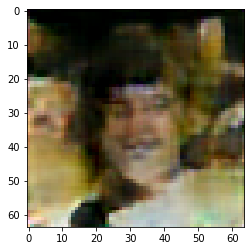

In [13]:
import torch as th
import matplotlib.pyplot as plt

create_grid(
    samples=c_pro_gan.gen(
        fixed_gan_input,
        4,
        1.0
    ),
    scale_factor=1,
    img_file='output.png')

img = plt.imread('output.png')
plt.figure()
plt.imshow(img)

In [34]:
  fixed_captions

('an older adult man looking somewhat cofused, angry or anxious. he seems to be from a mediterran area.',)